In [2]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 
%matplotlib notebook
%matplotlib inline

import ipysh

%aimport models.base

import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH
%aimport models.AEFIT5


Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


In [3]:

import livelossplot.keras
class PlotLossesCallback(livelossplot.keras.PlotLossesCallback):
    def on_train_batch_begin(self, a, b): pass
    def on_train_batch_end(self, a, b): pass
    def on_test_begin(self, a): pass
    def on_test_end(self, a): pass
    def on_test_batch_begin(self, a, b): pass
    def on_test_batch_end(self, a, b): pass

    
class PlotRelevanceCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(13, 3)
        w = self.model.layers[0].weights
        ax1.bar(range(0,4), w[0][0:4])
        labels = ['Ip','NS','Vt','F']
        plt.sca(ax1)
        plt.xticks(range(0,4), labels, fontsize=10)
        ax2.bar(range(7,17), w[0][4:14])
        plt.sca(ax2)
        plt.xticks(range(7,17), fontsize=10)        
        ax3.bar(range(7,17), w[0][14:24])
        plt.sca(ax3)
        plt.xticks(range(7,17), fontsize=10)       

Using TensorFlow backend.


In [4]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15u_shuffle.npy'
try: qsh.load(file)
except: raise FileNotFoundError

# qsh.shuffle()
qsh.dim = None
qsh.set_null(np.nan)
qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F','absBr_rm','argBr_rm','absBt_rm','argBt_rm']) 

print("QSH rebalanced 15 points size: ", len(qsh))

QSH rebalanced 15 points size:  47567


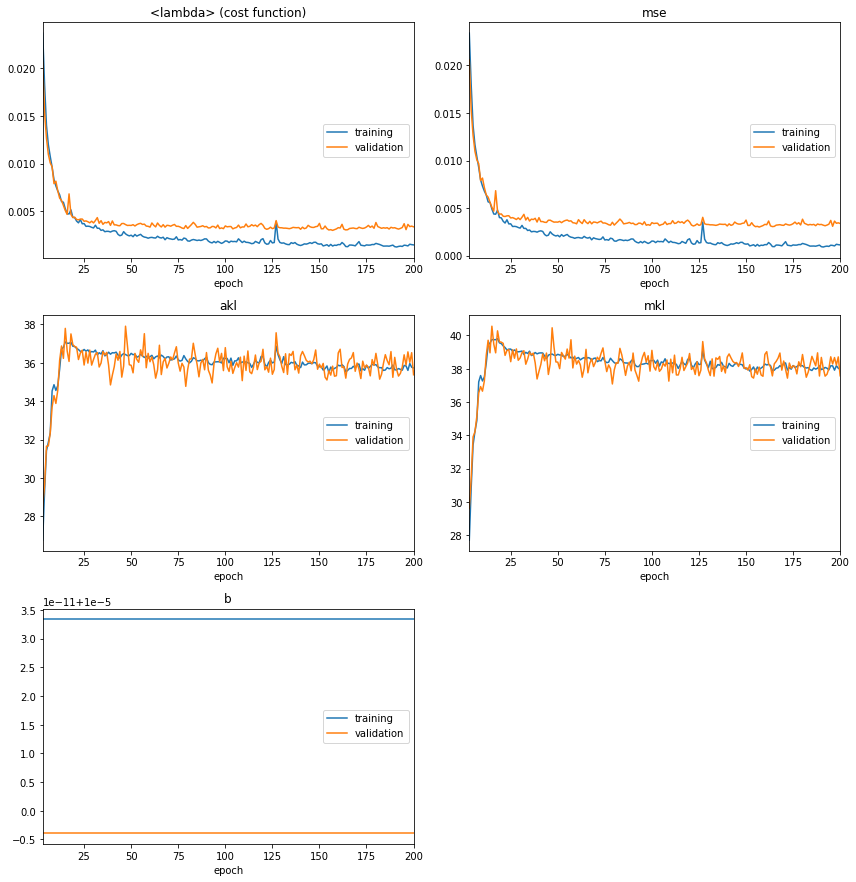

<lambda> (cost function):
training   (min:    0.001, max:    0.043, cur:    0.001)
validation (min:    0.003, max:    0.039, cur:    0.003)

mse:
training   (min:    0.001, max:    0.043, cur:    0.001)
validation (min:    0.003, max:    0.039, cur:    0.003)

akl:
training   (min:   13.773, max:   37.091, cur:   35.735)
validation (min:    9.781, max:   37.909, cur:   35.377)

mkl:
training   (min:   11.613, max:   39.810, cur:   37.970)
validation (min:   11.527, max:   40.559, cur:   37.577)

b:
training   (min:    0.000, max:    0.000, cur:    0.000)
validation (min:    0.000, max:    0.000, cur:    0.000)
426/426 [==============================] - 32s 74ms/step - loss: 0.0015 - mse: 0.0011 - akl: 35.7355 - mkl: 37.9696 - b: 1.0000e-05 - val_loss: 0.0034 - val_mse: 0.0034 - val_akl: 35.3774 - val_mkl: 37.5768 - val_b: 1.0000e-05


In [18]:
ds_m2 = qsh.tf_tuple_compose(['absBr_rm~argBr_rm~absBt_rm~argBt_rm']).map(lambda x: (x,x))

h = {
    'iR': [],
    'gR': [],
}
def train(e=200):
    m2 = models.AEFIT5.AEFIT5(latent_dim=10, feature_dim=40,  dprate=0., scale=1.5, geometry=[20,20,20,10,10], beta=1e-5,name='m2') # parameters
    def fit2():
        m2.fit( ds_m2.skip(5000).batch(100), validation_data=ds_m2.take(5000).batch(100),
                     callbacks=[PlotLossesCallback()], shuffle=False, epochs=e )
    fit2()
    iR = m2.inference_net.get_layer(m2.name+'_iRlv').weights[0]
    gR = m2.generative_net.get_layer(m2.name+'_gRlv').weights[0]
    return (iR,gR)

for i in range(50):
    iR,gR = train(200)
    h['iR'].append(iR)
    h['gR'].append(gR)
    

In [22]:
# import json
# with open('STEP12_VAE_modes_reconstruction.json', 'w') as fp:
#     json.dump(h, fp)    

# try:
#     import cPickle as pickle
# except ImportError:  # python 3.x
#     import pickle

# with open('STEP12_VAE_modes_reconstruction.p', 'wb') as fp:
#     pickle.dump(h, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle

with open('STEP12_VAE_modes_reconstruction.p', 'rb') as fp:
    global h
    h = pickle.load(fp)

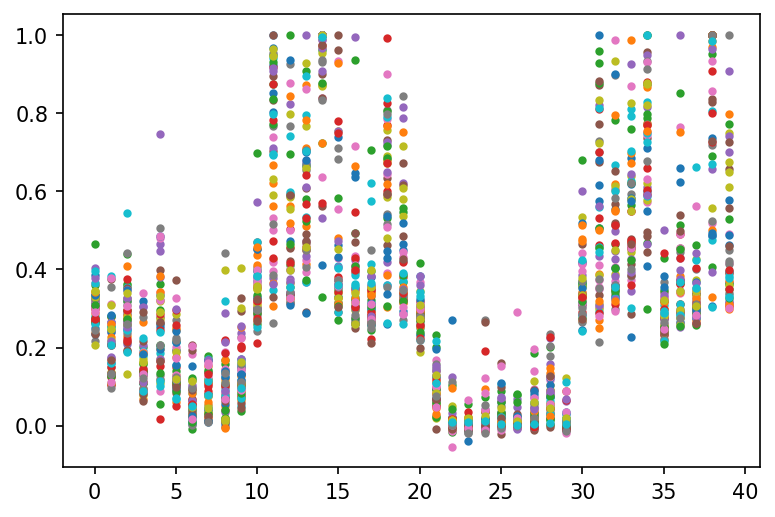

In [9]:
f = plt.figure('iR')
f.set_dpi(150)
for i in h['iR']:
    plt.plot(i.numpy(), '.')

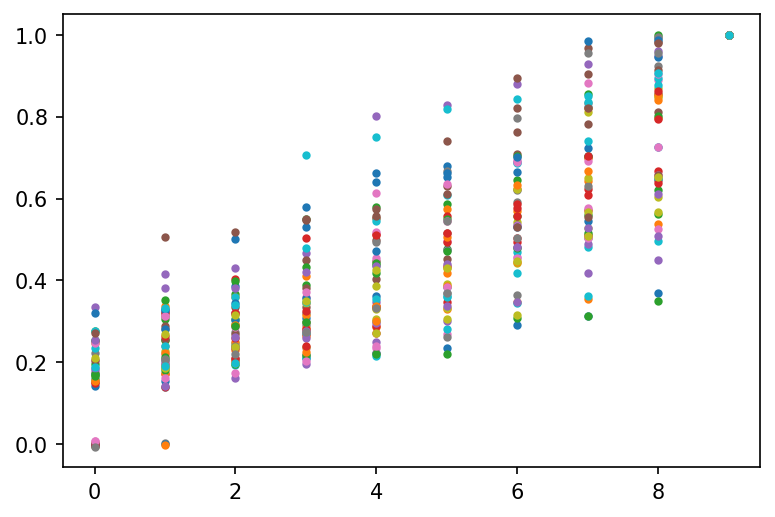

In [16]:
f = plt.figure('gR')
f.set_dpi(150)
for i in h['gR']:
    i = i.numpy()
    i = np.sort(i)
    plt.plot(i, '.')
